# Model Criticism for Bayesian Causal Inference

**Author**: Leo Guelman


## Imports <a class="anchor" id="imports21"></a>

In [35]:
import os
os.chdir('/Users/lguelman/Library/Mobile Documents/com~apple~CloudDocs/LG_Files/Development/MCBCI/python')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
parameters = {'figure.figsize': (8, 4),
              'font.size': 6, 
              'axes.labelsize': 10}
plt.rcParams.update(parameters)
plt.style.use('fivethirtyeight')
from IPython.display import Image

import pystan
import multiprocessing
import stan_utility
import arviz as az

import seaborn as sns
from utils import stan_model_summary, DataGeneratingProcess

## Generate syntehic data 

We follow Section 4.1. for sythetic data generation with minor variants. We generate 500 data points, each with a 10-dimensional covariate $x_i$, a binary treatment $a_i$, and a set of potential outcomes $(y_i(0), y_i(1))$,

\begin{align*} 
x_i &\sim  \text{Uniform}\big(x_i~\vert~[0,1]^{10} \big), \\ 
a_i~\vert~x_i &\sim \text{Bernoulli} \big(a_i~\vert~ \text{logistic}(x_i^\intercal \phi)  \big) \\
y_i(a)~\vert~x_i &\sim \mathscr{N} \big(y_i(a)~\vert~[x_i,a]^\intercal \theta, \sigma^2  \big).
\end{align*}

We place a standard normal prior over the parameters $\phi$, $\theta$, and a gamma prior with unit shape and rate on $\sigma^2$. We assume no correlation $\rho$ between potential outcomes below. However, this can be modified by changeing the parameter `rho`.

In [2]:
dgp = DataGeneratingProcess(N=500, d=10, rho=0.0, seed=432)
data = dgp.generate_data()
data.df

,y_obs,y_mis,y0,y1,tau_unit,a,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,-0.355080,1.924043,-0.355080,1.924043,2.279124,0,0.903661,0.896010,0.589950,0.987273,0.851603,0.208817,0.766623,0.032806,0.296746,0.570360
1,2.246395,-0.049397,-0.049397,2.246395,2.295791,1,0.834669,0.160730,0.348411,0.030891,0.986353,0.501477,0.437794,0.652700,0.470989,0.948481
2,2.486919,4.878609,2.486919,4.878609,2.391690,0,0.587839,0.020352,0.817677,0.977189,0.177341,0.849895,0.906638,0.699583,0.717297,0.576994
3,3.665241,1.605872,1.605872,3.665241,2.059369,1,0.398804,0.246183,0.523785,0.471349,0.020301,0.634659,0.927902,0.888842,0.703946,0.204001
4,-0.151500,1.480845,-0.151500,1.480845,1.632345,0,0.836528,0.774359,0.919492,0.569234,0.779445,0.185953,0.868888,0.660685,0.276374,0.231046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.011190,2.039205,0.011190,2.039205,2.028015,0,0.621539,0.915605,0.606129,0.818001,0.221810,0.684723,0.639255,0.157652,0.979599,0.064534
496,3.286602,0.806697,0.806697,3.286602,2.479904,1,0.593499,0.713316,0.609092,0.450044,0.069620,0.503841,0.571416,0.575057,0.662503,0.689368
497,1.815444,3.980675,1.815444,3.980675,2.165231,0,0.316736,0.763296,0.181927,0.506575,0.361373,0.995647,0.226801,0.827097,0.517792,0.622547
498,3.007869,0.867875,0.867875,3.007869,2.139993,1,0.064120,0.253654,0.339305,0.258092,0.032000,0.290471,0.342010,0.493644,0.510703,0.632596


## Model-Based Inference 

We approximate the posterior with MCMC in [Stan](https://mc-stan.org/).

### Case A: The Correct Model

Assume we implement a model that is faithful to the specification above.

In [3]:
stan_data_dict = {'N': data.N,
                  'd_a': data.d,
                  'd_o': data.d,
                  'X_a': data.X,
                  'X_o': data.X,
                  'y': data.y_obs,
                  'a': data.a,
                  'rho': 0.0,
                  'a_miss':0,
                  }

sm = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_a = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2965b5d830e1f7c79fb546c85c96425 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Case B: Misspecified Outcome Model

Assume we misspecify the distribution over $y_i(a)$ by ignoring the first entry on $x_i$ (i.e., $\theta_1=0$).

In [4]:
stan_data_dict_b = {'N': data.N,
                    'd_a': data.d,
                    'd_o': data.d-1,
                    'X_a': data.X,
                    'X_o': data.X[:,1:10],
                    'y': data.y_obs,
                    'a': data.a,
                    'rho': 0.0,
                    'a_miss':0,
                   }

sm_b = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_b = sm_b.sampling(data=stan_data_dict_b, iter=1000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2965b5d830e1f7c79fb546c85c96425 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Case C: Misspecified Assignment Model

Assume we misspecify the distribution over $a_i$ by setting the probability that $a_i=1$ to: $0.7+0.3 \times \text{logistic}(x_i^\intercal \phi)$.



In [5]:
stan_data_dict_c = {'N': data.N,
                    'd_a': data.d,
                    'd_o': data.d,
                    'X_a': data.X,
                    'X_o': data.X,
                    'y': data.y_obs,
                    'a': data.a,
                    'rho': 0.0,
                    'a_miss':1,
                    }


In [6]:
sm_c = pystan.StanModel('../stan/mbi_stan.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_c = sm_c.sampling(data=stan_data_dict_c, iter=1000, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2965b5d830e1f7c79fb546c85c96425 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Criticism - Assignment Model

Reference vs. Realized discrepancy: use mean probability of assignment instead of log-likelihood.


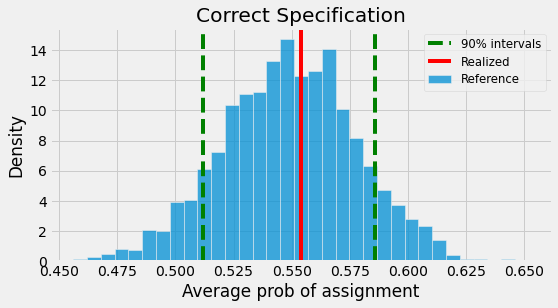

In [48]:
samples_a = fit_a.extract(permuted=True)

p_phi_a = samples_a['phi']
p_a_rep_a = samples_a['a_rep']

p = sns.histplot(data=np.mean(p_a_rep_a, axis=1), stat="density", label="Reference") 
p.set(xlabel='Average prob of assignment', title='Correct Specification')
plt.axvline(np.quantile(np.mean(p_a_rep_a, axis=1), .1), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(p_a_rep_a, axis=1), .9), color='g', linestyle='--')
plt.axvline(np.mean(data.a), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')



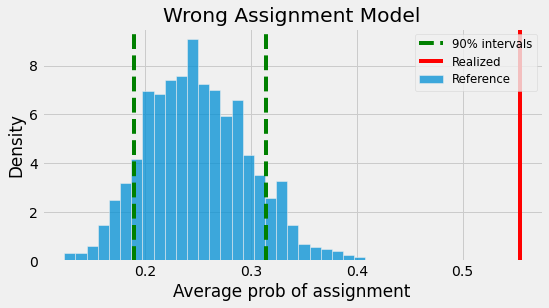

In [50]:
samples_c = fit_c.extract(permuted=True)

p_phi_c = samples_c['phi']
p_a_rep_c = samples_c['a_rep']

p = sns.histplot(data=np.mean(p_a_rep_c, axis=1), stat="density", label="Reference")
p.set(xlabel='Average prob of assignment', title='Wrong Assignment Model')
plt.axvline(np.quantile(np.mean(p_a_rep_c, axis=1), .1), color='g', linestyle='--', label='90% intervals')
plt.axvline(np.quantile(np.mean(p_a_rep_c, axis=1), .9), color='g', linestyle='--')
plt.axvline(np.mean(data.a), color='r', label='Realized')
plt.legend(loc="upper right", fontsize='small')

## 2.2 Data  <a class="anchor" id="data22"></a>

In [ ]:
df = pd.read_csv("../data/synthetic_data.csv")
df
df.info()
df.describe()

## 2.3 Assessing Balance of Covariates <a class="anchor" id="balance23"></a>

Covariate balance is the degree to which the distribution of covariates is similar across levels of the treatment. Here we assess the extent to which the treatment assignment was uniformly randomized across observational units, or there are some selection effects. To that end, we use *Prognostic scores* (Hansen 2008). The prognostic score is defined as the predicted outcome under the control condition, reflecting the baseline "risk", i.e., $E(Y|X, Z=0)$. It is estimated by fitting a model of the outcome in the control group, and then using that model to obtain predictions of the outcome under the control condition for all individuals. The standardize difference in the mean prognostic scores between treatment and control groups is used as a measure of covariate balance. 

Here we fit a Bayesian linear regression model to get a posterior distribution of the standardize difference in the mean prognostic scores between treatment and control groups.

We first pre-process the data (encode categorical features and scaling).

In [ ]:
X, z, y, *_ = pre_process_data(df, standardize_x=False, interactions=False, 
                               p_score=None, drop_first=False)

print("Features dimension:", X.shape)
print("Treatment dimension:", z.shape)
print("Response dimension:", y.shape)
print("Number of treated / control units:", sum(z), "/", X.shape[0]-sum(z))

We now fit the model in [stan](https://mc-stan.org/). We place the stan code separately in `stan_linear_reg.stan`, stored in the repo.

In [ ]:
n, p = X[z==0,:].shape # Fit model using control units only

stan_data_dict = {'N': n,
                  'K': p,
                  'x': X[z==0,:],
                  'y': y[z==0],
                  'N_new': X.shape[0],
                  'x_new': X
                  }

sm = pystan.StanModel('../stan/stan_linear_reg.stan') 
multiprocessing.set_start_method("fork", force=True)
fit = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

In [ ]:
fit_summary = stan_model_summary(fit)
fit_summary

The standardize mean difference in Prognostic scores is positive meaning that students with highest potential outcomes under control are more likely to receive treatment. This can also be appreciated by plotting the proportion of individuals assigned to treatment for by quantile of the prognostic score (each quantile comprises about 1/5 of the observations). In this case, we say that the treatment assignment mechanisms is *counfounded* with the potential outcomes.

In this context, a simple comparison of treated versus control individuals would produce bias estimates of treatment effects (both average and conditional effects). Therefore, appropriately accounting for confounding is a first-order concern. We thus proceed the analysis as an observational study instead on a randomized one. Specifically, to address this problem we directly incorporate an estimate of the *propensity score* in the specification of the outcome model, implicitly inducing a covariate dependent prior on the regression function (see Hahn 2020).




In [ ]:
# Extract prognostic scores
samples = fit.extract(permuted=True)
prog_scores = samples['prog_scores'].T

# Compute mean and standardize mean differences in scores
mcmc_samples = prog_scores.shape[1]
prog_scores_diff = np.zeros(mcmc_samples)
prog_scores_std_diff = np.zeros(mcmc_samples)

for s in range(mcmc_samples):
    prog_scores_diff[s] = np.mean(prog_scores[z==1,s]) - np.mean(prog_scores[z==0,s])
    prog_scores_std_diff[s] = prog_scores_diff[s] / np.std(prog_scores[:,s])
  
                               
plt.hist(prog_scores_std_diff, bins = 30)
plt.title("Standardized mean difference in Prognostic scores", fontsize=12)
plt.show()  


In [ ]:
# Compute proportion treated by mean prognostic score quantile
prog_scores_df = pd.DataFrame({'prog_score_mean': np.mean(prog_scores, axis =1),'z':z})
prog_scores_df['prog_score_mean_quantile']= pd.qcut(prog_scores_df['prog_score_mean'], 
                                                    q = 5, labels = False)+1
prog_scores_df.groupby(['prog_score_mean_quantile'])['z'].mean().plot(xticks=list(range(1,6)), 
                                                                     xlabel='Mean Prognostic Score (Quantile)',
                                                                     ylabel='Proportion Treated')

## 2.4 Propensity Score <a class="anchor" id="propscore24"></a>

The propensity score is the probability of treatment assignment conditional on observed baseline covariates, i.e., $E(Z|X)$. Here we fit the propensity score using a flexible non-linear specification based on a Gradient Boosting method. Parameter tuning is done via cross-validated random search.

In [ ]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

n_folds = 3
param_n_picks = 30

xgb = XGBClassifier(learning_rate=0.01, n_estimators=500, objective='binary:logistic',
                    silent=True, nthread=1)

skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

xgb_fits = RandomizedSearchCV(xgb, param_distributions=param_grid,
                              n_iter=param_n_picks, scoring='roc_auc', n_jobs=-1, 
                              cv=skf.split(X,z), verbose=3, random_state=42)

xgb_fits.fit(X, z)

print('\n Best estimator:')
print(xgb_fits.best_estimator_)
#print('\n Best AUC score:')
#print(xgb_fits.best_score_)
print('\n Best hyperparameters:')
print(xgb_fits.best_params_)

# We now fit the best estimator to all train data 
best_fit = xgb_fits.best_estimator_.fit(X, z)
pscore = best_fit.predict_proba(X)[:,1]
log_odds_pscore = np.log(pscore /(1-pscore))

In [ ]:
prop_score_df = pd.DataFrame({'log_odds_pscore': log_odds_pscore, 'Z':z})
sns.displot(prop_score_df, x="log_odds_pscore", 
            hue="Z",  stat="density", common_norm=False)

## 2.5 Model-based Inference <a class="anchor" id="mbinference25"></a>


We implement the Bayesian inference framework for causal effects introduced by Rubin (1978). In this framework, each observational unit $i=\{1,\ldots, N\}$ is seen as having a potential outcome for each level of treatment. In the binary treatment case with $Z \in [0,1]$, $Y_i(1)$ and $Y_i(0)$ represent the potential outcomes of unit $i$ under $Z=1$ and 
$Z=0$, respectively. Causal inference is considered a missing data problem since both potential outcomes are never jointly observed. Specifically, observed and missing outcomes can be expressed in terms of the potential outcomes as follows:

\begin{align*} 
Y_i^{\text{obs}} &=  Y_i(1)Z_i + Y_i(0)(1-Z_i) \\ 
Y_i^{\text{mis}} &=  Y_i(1)(1-Z_i) + Y_i(0)Z_i
\end{align*}


From a Bayesian perspective, $Y_i^{\text{mis}}$ is considered a latent variable, similar to any other latent variable in the model (I'm trying to avoid the term "parameters" here, which is more common in the frequentist language). The missing potential outcomes can be imputed by estimating their posterior predictive distribution given the observed data. That is,

$$
\text{Pr}(Y^{\text{mis}}| Y^{\text{obs}},Z, X).
$$

Estimating the conditional distribution of $Y^{\text{mis}}$ given $(Y^{\text{obs}},Z, X)$, requires building a model of the joint distribution of potential outcomes $(Y(0), Y(1))$. We assume that the true underlying model for the potential outcomes follows a bivariate Gaussian, 

$$
\begin{pmatrix}
Y_i(0) \\
Y_i(1) 
\end{pmatrix} \bigg\lvert~X_i, \theta \sim N \left(\begin{pmatrix}
\alpha + X_i\beta_c \\
\alpha + X_i\beta_t + \tau
\end{pmatrix},\begin{pmatrix}
\sigma_c^{2} & \rho\sigma_c\sigma_t \\
\rho\sigma_c\sigma_t & \sigma_t^{2}
\end{pmatrix}\right),
$$

where $\theta=(\alpha, \beta_c, \beta_t, \tau, \sigma_c^2, \sigma_t^2, \rho)$.

From this model, we can derive the conditional distribution of each potential outcome as


\begin{align*} 
\text{Pr}(Y_i(1) | Y_i(0), \theta, Z_i=0) &\sim N \Big(\mu_t+ \rho \frac{\sigma_t}{\sigma_c} (Y_i(0)-\mu_c), \sigma^2_t(1-\rho^2)\Big),\\
\text{Pr}(Y_i(0) | Y_i(1), \theta, Z_i=1) &\sim N \Big(\mu_c+ \rho \frac{\sigma_c}{\sigma_t} (Y_i(1)-\mu_t), \sigma^2_c(1-\rho^2)\Big), 
\end{align*}

where $\mu_c = \alpha + X\beta_c$, and $\mu_t = \alpha + X\beta_t + \tau$.

From the distribution of potential outcomes, we can infer the distribution of any estimand of interest of the form $\tau = \tau(Y(0),Y(1), X, Z)$. For instance, the average treatment effect (ATE) can be obtained by simply computing $\frac{1}{N}\sum_{i=1}^N(Y_i(1)-Y_i(0))$. This is also known as the "finite sample" ATE. If instead, we view the observations as a sample from an infinite super-population, then the super-population ATE is given from the posterior distribution of $\tau$.

A few observations from the model above:

* Since $Y_i(0)$ and $Y_i(1)$ are never jointly observed, the correlation between outcomes, $\rho$, cannot be estimated empirically. It must be based on subject-matter knowledge. Sometimes we may choose to be "conservative" about this dependence and therefore assume the worst case. In terms of the posterior variance, the worst case is often the situation of perfect correlation between the two potential outcomes.

* There are two sources of uncertainty in the predictive distribution of the missing potential outcomes: the first is the uncertainty in the estimated latent variables (a.k.a., *epistemic uncertainty*), and the second in the uncertainty in the data as expressed by the Gaussian random sampling mechanism (a.k.a., *aleatoric uncertainty*).

* We allow for heterogeneous treatment effects - i.e., we define two different vectors $\beta_c$ and  $\beta_t$, for control and treated units, respectively. In the **Stan** model below (see `stan_mbi.stan`), this heterogeneity is expressed by including interaction terms between each covariate and the treatment. The posterior estimates on the interaction effects represent the incremental effect of treatment $\beta_t - \beta_c$.

* The propensity score is considered as an additional covariate in $X$.



In [ ]:
X,z, y, a_effects, m_effects, i_effects = pre_process_data(df, standardize_x=False, interactions=True, 
                                                            p_score=pscore, drop_first=False)

# Get indexes of main and interaction effects
idx_m_effects = [a_effects.index(i) for i in m_effects]
idx_i_effects = [a_effects.index(i) for i in i_effects]

print(X.shape)
print(len(idx_m_effects))
print(len(idx_i_effects))
print(X[:,idx_m_effects].shape)
print(X[:,idx_i_effects].shape)

In [ ]:
stan_data_mbi = {'N': X.shape[0], 
                 'N_main_cov':len(idx_m_effects),
                 'N_inter_cov':len(idx_i_effects),
                 'y': y,
                 'z': z,
                 'x': X[:,idx_m_effects],
                 'xz_inter': X[:,idx_i_effects],
                 'rho':0.0}

sm = pystan.StanModel('../stan/stan_mbi.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_mbi = sm.sampling(data=stan_data_mbi, iter=1000, chains=4, seed=194838)

### 2.5.1 MCMC Diagnostics <a class="anchor" id="mcmcdiagn251"></a>


In [ ]:
summary_stan_fit = stan_model_summary(fit_mbi)
summary_stan_fit

In [ ]:
r_hat = summary_stan_fit['Rhat']
r_hat.plot.hist(title="Rhat")
plt.axvline(1.1, color='r', linestyle='--')

In [ ]:
summary_stan_fit['n_eff'].plot.hist(title="n_eff")

In [ ]:
stan_utility.utils.check_treedepth(fit_mbi)

In [ ]:
stan_utility.utils.check_energy(fit_mbi)

In [ ]:
stan_utility.utils.check_div(fit_mbi)

### 2.5.2  Effectiveness of Intervention<a class="anchor" id="effint252"></a>

Here we address the first study question, which we recall is "*Was the mindset intervention effective in improving student achievement?*" This relates to the *Average Treatment Effect (ATE)*. The estimated (finite-sample) **ATE is 0.24 with a 95% uncertainty interval between 0.22 and 0.26. The true value based on the simulation is also 0.24**, so we are right on spot. 

In [ ]:
taus = summary_stan_fit.loc[['tau_fs']]
taus

For comparison purposes, we show below the submitted estimates for average treatment effects and corresponding 95% uncertainty intervals from eight ACIC 2018 challenge participants (Carvalho 2019). Our estimate is closer to the true value relative to all submissions.

In [ ]:
Image(filename = "../img/acic_ate.png", width = 300, height = 200)

### 2.5.3  Treatment effect variation across `X1` and `X2` <a class="anchor" id="hetero253"></a>

The second question of the study is directed to assess the treatment effect variation across the two pre-specified moderators, `X1` (pre-existing mindset norms) and `X2` (school level achievement).

We look at the posterior estimates of interaction effects `Z x X1` and `Z x X2`. This effect represent the incremental effect of treatment $\beta_t - \beta_c$ from `X1` and `X2`. The results depicted below indicate that a higher baseline mindset beliefs tends to be associated with lower treatment effect on average. In contrast, there appears to be no support for treatment effect variation across school achievement levels. 

In [ ]:
samples = fit_mbi.extract(permuted=True)

Z_X1_samples = samples['beta_inter'][:,i_effects.index('Z_X1')]
Z_X2_samples = samples['beta_inter'][:,i_effects.index('Z_X2')]

g1 = sns.displot(Z_X1_samples, kind="kde")
g1.set_axis_labels("Interaction effect (Z x X1) posterior samples", 
                  "Density", fontsize=10)

g2 = sns.displot(Z_X2_samples, kind="kde")
g2.set_axis_labels("Interaction effect (Z x X2) posterior samples", 
                  "Density", fontsize=10)

For comparisson purpose, we show below the results concerning whether the intervention was moderated by school level achievement (`X2`) from the eight participants. Results are clearly mixed, with half of the participants finding no support for variation across `X2`. The results from our analysis illustrating the uncertainty in the posterior distribution of this effect aligns with the inconclusive results from the participants.  

According to the true underlying data generating process, the impact of the intervention varies both on pre-existing mindset norms (`X1`) and school achievement level (`X2`), but without a "Golfilocks" effect present. 

In [ ]:
Image(filename = "../img/acic_het.png", width = 400, height = 300)

### 2.5.4 Individual Treatment Effects <a class="anchor" id="ite254"></a>

Probably one of the key benefits of the Bayesian approach is that we can get a distribution of the estimated treatment effect for each student (a.k.a., *individual treatment effect*). This is defined as the difference in potential outcomes, $Y(1)_i-Y(0)_i$. We show this for a sample student below.

In [ ]:
student = 989
ite = samples['tau_unit'][:,student] # same as samples['y1'][:,student] - samples['y0'][:,student]
sns.displot(ite, kind="kde")

# References <a class="anchor" id="ref"></a>

Carvalho, C., Feller, A., Murray, J., Woody, S., and Yeager, D. Assessing Treatment Effect Variation in Observational Studies: Results from a Data Challenge, (2019). https://arxiv.org/abs/1907.07592

Donald B. Rubin. Bayesian Inference for Causal Effects: The Role of Randomization. Ann. Statist. 6 (1) 34 - 58 (1978). https://doi.org/10.1214/aos/1176344064

Hahn, P.R., Murray, J.S., Carvalho, C.M. Bayesian Regression Tree Models for Causal Inference: Regularization, Confounding, and Heterogeneous Effects (with Discussion). Bayesian Analysis. 15 (3) 965 - 1056 (2020). https://doi.org/10.1214/19-BA1195

Hansen, Ben B. The Prognostic Analogue of the Propensity Score. Biometrika 95 (2), 481–88, (2008). https://doi.org/10.1093/biomet/asn004.

Yeager, D.S., Hanselman, P., Walton, G.M. et al. A national experiment reveals where a growth mindset improves achievement. Nature 573, 364–369 (2019). https://doi.org/10.1038/s41586-019-1466-y